# Stock Analysis Using LSTM - MVP (MULTI-ITERATION)
- train an LSTM on a variable number of features
- vary on lookback (LSTM window) and training window (years before present date)
- multi input version
- multi day lookahead (predict x days ahead) version
- this version is designed to ingest key parameters from a CSV files and perform multiple training and rendering iterations based on the values in the CSV file
- APR 15 updates: writing a single output CSV file for a single input CSV file
- APR 24 updates: added VIX as an optional feature
- MAY 6 updates: cleaned up defect when ticker missing from sector CSV; added new features: 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment'

This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [1]:
! python --version

Python 3.7.4


In [2]:
! pip install quandl
#! pip install pip --upgrade
#! pip install pandas-datareader
print("past pandas_datareader")
#! pip install yahoo_fin
import pandas as pd
import numpy as np
import os
import yaml
from datetime import date
import requests
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
#import pandas_datareader as pdr
from pandas_datareader.data import DataReader
# import yahoo_fin.stock_info as si

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.models import Model
# from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
# access datasets from quandl.com - need to pip install Quandl to use
import quandl
on_colab = False
verboseout = True
results_columns = ['ticker','total deviation','avg deviation','max deviation','min deviation','proportion good days']    
config_file = 'model_training_config.yml'
feature_df_dict = {}

You should consider upgrading via the 'c:\users\ryanm\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [4]:
'''
r = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')
print(r.json())
'''

"\nr = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')\nprint(r.json())\n"

In [5]:
start_timestamp = datetime.now()
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

# Load config parameters

In [7]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, config_file)
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [8]:
# set parameters
# parameters that could change if the CSV file is used to drive multiple runs are set in the dictionary parms
parms = {}
parms['repeatable_run'] = config['general']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if parms['repeatable_run']:
    from numpy.random import seed
    seed(4)
    # dumb switch to make up for dumb regression going from TF 1 to TF 2
    if tf.__version__ == '1.15.0':
        tf.set_random_seed(7)
    else:
        tf.random.set_seed(7)


#master_date_mode', 'master_start', 'master_end',
#       'repeatable_run', 'years_window', 'training_proportion',
#       'close_threshold', 'look_back', 'look_ahead', 'look_ahead_scale',
#       'tech_list'
list_parms = ['tech_list']
plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
ust_cols = config['general']['ust_cols']
report_round = config['general']['report_round']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
parms['tech_list'] = config['tech_list']
# dictionary to seed stock handles with company names
saved_model_modifier = config['files']['saved_model_modifier']
# get the column lists
parms['close_threshold'] = config['general']['close_threshold']
quandl_token = config['general']['quandl_token']
# number of days previous used to predict subsequent day
parms['look_back'] = config['general']['look_back']
# gap in day betwen the last day previous and the subsequent day being predicted
parms['look_ahead'] = config['general']['look_ahead']
parms['look_ahead_scale'] = config['general']['look_ahead_scale']
parms['years_window'] = config['general']['years_window']
# target column
lstm_target = config['general']['lstm_target']
# list from target column
lstm_target_list = [lstm_target]
# additional features beyond the target column
feature_list = config['general']['feature_list']
# complete list of features LSTM trained on
lstm_feature_list = lstm_target_list+feature_list
# switch to determine normalization method
min_max_norm = config['general']['min_max_norm']
eod_token = config['general']['eod_token']
sector_ticker = config['files']['sector_ticker']
multi_parm_file = config['files']['multi_parm_file'] # CSV file containing parms for multiple runs
debug_on = config['general']['debug_on']
max_years_back = config['general']['max_years_back']
parms['master_date_mode'] = config['general']['master_date_mode']
parms['master_start'] = config['general']['master_start']
parms['master_end'] = config['general']['master_end']
parms['training_proportion'] = config['general']['training_proportion']

multi_parm_run = config['general']['multi_parm_run']
# ensure value of training_proportion is valid
if (parms['training_proportion'] < 0.25) or (parms['training_proportion'] > 0.9):
    print("setting default training proportion")
    parms['training_proportion'] = 0.8

In [9]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'debug_on': False,
  'presaved': False,
  'savemodel': False,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'min_max_norm': True,
  'master_date_mode': False,
  'master_start': '2010-01-01',
  'master_end': '2016-01-01',
  'repeatable_run': False,
  'years_window': 2,
  'max_years_back': 20,
  'training_proportion': 0.8,
  'close_threshold': 0.01,
  'report_round': 4,
  'ust_cols': ['2 YR'],
  'quandl_token': 'uCghYBw8CtpUvWct_W8c',
  'finnhumb_key': 'c16hj0f48v6ppg7erf7g',
  'eod_token

# Ingest Sector Ticker file
- ingest CSV file that contains correlation between stock ticker symbols and ETF tickers as a proxy for sector tickers

In [10]:
def get_data_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

In [11]:
sector_file = os.path.join(get_data_path(),sector_ticker)
print("sector_file: ",sector_file)
df_sector = pd.read_csv(sector_file,encoding = "ISO-8859-1")
df_sector.head()

sector_file:  C:\personal\karma_stocks_2021\stock_investigation\data\sector_ticker.csv


,Symbol,Name,Sector,Sector Ticker,Sector ETF Ticker,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,A,Agilent Technologies Inc,Health Care,^SP500-35,IYH,NaN,- 'A',NaN,NaN,NaN,NaN
1,AAL,American Airlines Group,Industrials,^SP500-20,IYJ,NaN,- 'AAL',NaN,NaN,NaN,NaN
2,AAP,Advance Auto Parts,Consumer Discretionary,^SP500-25,XLY,NaN,- 'AAP',NaN,NaN,NaN,NaN
3,AAPL,Apple Inc.,Information Technology,^SP500-45,IYW,NaN,- 'AAPL',NaN,NaN,NaN,NaN
4,ABBV,AbbVie Inc.,Health Care,^SP500-35,IYH,NaN,- 'ABBV',NaN,NaN,NaN,NaN


# Experiment getting Sector value from Yahoo API
- set company to stock ticker
- set start and end to define timeframe

In [12]:
end = datetime.now()
start = datetime(end.year-20, end.month, end.day)
#start = datetime(end.year, end.month, end.day-7)
print("start is: ",str(start))
print("end is: ",str(end))
# start = datetime(end.year - parms['years_window'], end.month, end.day)
company = 'VOO'
df_test = DataReader(company,data_source='yahoo', start=start, end=datetime.now())
df_test.head(10)

start is:  2001-05-06 00:00:00
end is:  2021-05-06 22:24:59.243470


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-09-09,102.500000,101.139999,102.500000,101.320000,26500.0,82.194580
2010-09-10,101.860001,101.300003,101.680000,101.779999,8600.0,82.567719
2010-09-13,103.139999,102.500000,102.959999,103.059998,33750.0,83.606148
2010-09-14,103.480003,102.379997,102.839996,103.040001,59400.0,83.589928
2010-09-15,103.379997,102.400002,102.620003,103.300003,9250.0,83.800819
2010-09-16,103.320000,102.699997,103.019997,103.260002,59550.0,83.768394
2010-09-17,103.879997,103.019997,103.879997,103.360001,49350.0,83.849533
2010-09-20,105.040001,103.459999,103.739998,105.040001,19000.0,85.212402
2010-09-21,105.440002,104.279999,105.019997,104.720001,19250.0,84.952812


# Define start and end of analysis period

In [13]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
# check to see if start and end dates are hard-coded with master dates
def set_start_end():
    if parms['master_date_mode']: # start and end hardcoded by parameters
        start = parms['master_start']
        end = parms['master_end']
    else: # end is current date; start is current date minus years_window
        end = datetime.now()
        start = datetime(end.year - parms['years_window'], end.month, end.day)
    # output a test dataset
    tester = DataReader('IBM', 'yahoo', start, end)
    print(tester.shape)
    return(start,end)

# Experiment with EOD API for dividend
- EOD historical data doesn't directly support Python access
- https://eodhistoricaldata.com/financial-apis/python-example/




In [14]:
import requests

import pandas as pd

from io import StringIO

# URL for dividend data
# https://eodhistoricaldata.com/api/div/AAPL.US?api_token=OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX&from=2000-01-01

def get_div_data(symbol='AAPL.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', session=None):
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/div/%s' % symbol
    params = {'api_token': api_token}
    r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0], index_col=0, engine='python')
        return(True, df)
    else:
        print("status code",str(r.status_code))
        print("reason code",str(r.reason))
        return(False,"null")
        #raise Exception(r.status_code, r.reason, url)

# Load US Treasury stats

In [15]:
# load US Treasury yield dataframe
ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)

In [16]:
ust_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,0.01,0.02,0.01,0.03,0.05,0.16,0.35,0.86,1.32,1.65,2.19,2.30
2021-05-03,0.02,0.02,0.04,0.04,0.06,0.16,0.33,0.84,1.29,1.63,2.18,2.30
2021-05-04,0.01,0.01,0.02,0.04,0.06,0.16,0.33,0.82,1.28,1.61,2.16,2.27


In [17]:
# new = old[['A', 'C', 'D']].copy()
ust_df_2year = ust_df[['2 YR']].copy()
ust_df_2year.head()

,2 YR
Date,
1990-01-02,7.87
1990-01-03,7.94
1990-01-04,7.92
1990-01-05,7.90
1990-01-08,7.90


# Load Personal saving rate

In [18]:
# Personal Savings Rate: https://www.quandl.com/data/FRED/PSAVERT-Personal-Saving-Rate (monthly)
psr_df = quandl.get("FRED/PSAVERT", authtoken=quandl_token)
psr_df.head()

,Value
Date,
1959-01-01,11.3
1959-02-01,10.6
1959-03-01,10.3
1959-04-01,11.2
1959-05-01,10.6


In [19]:

psr_df.rename(columns={'Value':'personal_sav_rate'}, inplace=True)
feature_df_dict['personal_sav_rate'] = psr_df

# Load crude oil price

In [20]:
# Crude Oil price (WTI): https://www.quandl.com/data/FRED/DCOILWTICO-Crude-Oil-Prices-West-Texas-Intermediate-WTI-Cushing-Oklahoma (daily)
oil_df = quandl.get("FRED/DCOILWTICO", authtoken=quandl_token)
oil_df.head()

,Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


In [21]:
oil_df.tail()

,Value
Date,
2021-04-20,62.61
2021-04-21,61.34
2021-04-22,61.45
2021-04-23,62.18
2021-04-26,62.02


In [22]:
oil_df.rename(columns={'Value':'oil_price'}, inplace=True)
feature_df_dict['oil_price'] = oil_df

# Load Schiller Ratio

In [23]:
# Shiller PE Ratio by Month:  https://www.quandl.com/data/MULTPL/SHILLER_PE_RATIO_MONTH-Shiller-PE-Ratio-by-Month (monthly)
schiller_df = quandl.get("MULTPL/SHILLER_PE_RATIO_MONTH", authtoken=quandl_token)
schiller_df.head()

,Value
Date,
1871-02-01,10.92
1871-03-01,11.19
1871-04-01,12.05
1871-05-01,12.59
1871-06-01,12.59


In [24]:
schiller_df.tail()

,Value
Date,
2021-03-01,35.05
2021-03-31,35.74
2021-04-01,36.50
2021-04-30,37.56
2021-05-01,37.49


In [25]:
schiller_df.shape

(1818, 1)

In [26]:
schiller_df.rename(columns={'Value':'schiller_ratio'}, inplace=True)
feature_df_dict['schiller_ratio'] = schiller_df

# Load consumer sentiment


In [27]:
# Consumer Sentiment: https://www.quandl.com/data/UMICH/SOC1-University-of-Michigan-Consumer-Survey-Index-of-Consumer-Sentiment (monthly)
conf_df = quandl.get("UMICH/SOC1", authtoken=quandl_token)

In [28]:
conf_df.head()

,Index
Date,
1952-11-30,86.2
1953-02-28,90.7
1953-08-31,80.8
1953-11-30,80.7
1954-02-28,82.0


In [29]:
conf_df.tail()

,Index
Date,
2020-11-30,76.9
2020-12-31,80.7
2021-01-31,79.0
2021-02-28,76.8
2021-03-31,84.9


In [30]:
conf_df.shape

(611, 1)

In [31]:
conf_df.rename(columns={'Index':'consumer_sentiment'}, inplace=True)
feature_df_dict['consumer_sentiment'] = conf_df

# Parameters to incorporate
- Investor sentiment: https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
- GDP: https://www.quandl.com/data/FRED/GDP-Gross-Domestic-Product
- Consumer Price Index (as proxy for inflation): https://www.quandl.com/data/FRED/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items (I think these figures are derived from the same source I put in the factor spreadsheet: https://www.bls.gov/news.release/cpi.toc.htm)
- Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate

# Load investor sentiment

In [32]:
# investor sentiment
# https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
# weekly
inv_sent_df = quandl.get("AAII/AAII_SENTIMENT", authtoken=quandl_token)
inv_sent_df.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.380245,0.480891,0.279599,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.380245,0.480891,0.279599,314.59,307.63,314.59
1987-07-24,0.36,0.50,0.14,1.0,NaN,0.22,0.380245,0.480891,0.279599,311.39,307.81,309.27
1987-07-31,0.26,0.48,0.26,1.0,NaN,0.00,0.380245,0.480891,0.279599,318.66,310.65,318.66
1987-08-07,0.56,0.15,0.29,1.0,NaN,0.27,0.380245,0.480891,0.279599,323.00,316.23,323.00


In [33]:
inv_sent_df.tail()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
2021-03-25,0.509494,0.284810,0.205696,1.0,0.450599,0.303798,0.380245,0.480891,0.279599,3887.14,3864.63,3881.20
2021-04-01,0.458333,0.309524,0.232143,1.0,0.451054,0.226190,0.380245,0.480891,0.279599,4013.04,4013.04,4013.04
2021-04-08,0.569079,0.226974,0.203947,1.0,0.457611,0.365132,0.380245,0.480891,0.279599,4093.87,4089.89,4091.04
2021-04-15,0.538206,0.215947,0.245847,1.0,0.460250,0.292359,0.380245,0.480891,0.279599,4151.69,4120.87,4124.66
2021-04-22,0.526814,0.268139,0.205047,1.0,0.462819,0.321767,0.380245,0.480891,0.279599,4170.46,4160.11,4162.43


In [34]:
inv_sent_df.shape

(1762, 12)

In [35]:
# inv_sent_df2 = inv_sent_df[['Bullish','Bearish']].copy()
bullish_df = inv_sent_df[['Bullish']].copy()
bearish_df = inv_sent_df[['Bearish']].copy()
feature_df_dict['Bullish'] = bullish_df
feature_df_dict['Bearish'] = bearish_df

# Load GDP

In [36]:
gdp_df = quandl.get("FRED/GDP", authtoken=quandl_token)
gdp_df.tail()

,Value
Date,
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21494.731
2021-01-01,22048.894


In [37]:
gdp_df.rename(columns={'Value':'gdp'}, inplace=True)
feature_df_dict['gdp'] = gdp_df
gdp_df.tail()

,gdp
Date,
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21494.731
2021-01-01,22048.894


# Load CPI

In [38]:
cpi_df = quandl.get("FRED/CPIAUCSL", authtoken=quandl_token)
cpi_df.tail()

,Value
Date,
2020-11-01,260.927
2020-12-01,261.560
2021-01-01,262.231
2021-02-01,263.161
2021-03-01,264.793


In [39]:
cpi_df.rename(columns={'Value':'cpi'}, inplace=True)
feature_df_dict['cpi'] = cpi_df

# Load VIX
- special ticker to get options as proxies of where investors think the market is heading 
- source: Yahoo
- frequency: daily

In [40]:
# brute force to just get the VIX series for the last 20 years
vix_end = datetime.now()
vix_start = datetime(end.year-max_years_back, end.month, end.day)
print("vix_start: ",vix_start)
print("vix_end: ",vix_end)
company = '^VIX'
temp_df = DataReader(company,data_source='yahoo', start=vix_start, end=vix_end)
vix_df = temp_df[["Close"]].copy()
vix_df.rename(columns={'Close':'VIX'}, inplace=True)
vix_df.head()

vix_start:  2001-05-06 00:00:00
vix_end:  2021-05-06 22:25:20.223292


,VIX
Date,
2001-05-07,24.860001
2001-05-08,24.440001
2001-05-09,24.350000
2001-05-10,24.000000
2001-05-11,23.540001


In [41]:
vix_df.tail()

,VIX
Date,
2021-04-30,18.610001
2021-05-03,18.309999
2021-05-04,19.480000
2021-05-05,19.150000
2021-05-06,18.389999


# Load unemployment

In [42]:
# Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate
# monthly
unemp_df = quandl.get("FRED/UNRATE")
unemp_df.tail()

,Value
Date,
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2
2021-03-01,6.0


In [43]:
unemp_df.rename(columns={'Value':'unemployment'}, inplace=True)
feature_df_dict['unemployment'] = unemp_df

# Load dividends
- source is Yahoo

In [44]:
# this source is no good because it's a single entry, not a series
#quote_table = si.get_quote_table("aapl", dict_result=False)

In [45]:
#quote_table

# Join input dataframes

In [46]:
add_date = np.datetime64(date.today())
add_date
ass_feat = []
print("udf shape before: ",ust_df.shape)
for feature_df in feature_df_dict:
    print("filling in df for:",feature_df)
    # set the value of the end row
    feature_df_dict[feature_df].loc[add_date] = [feature_df_dict[feature_df][feature_df].iloc[-1]]
    # fill in the daily values
    feature_df_dict[feature_df] = feature_df_dict[feature_df].resample('D').ffill()
    print("shape of df: ",feature_df_dict[feature_df].shape)
    # join to main df
    ust_df = pd.merge(ust_df,feature_df_dict[feature_df],on=['Date'],how='inner')
    ass_feat.append(feature_df)
# add on VIX
ust_df = pd.merge(ust_df,vix_df,on=['Date'],how='inner')
print("udf shape after: ",ust_df.shape)
print("feature list is:",ass_feat)
    

udf shape before:  (7843, 12)
filling in df for: personal_sav_rate
shape of df:  (22772, 1)
filling in df for: oil_price
shape of df:  (12909, 1)
filling in df for: schiller_ratio
shape of df:  (54882, 1)
filling in df for: consumer_sentiment
shape of df:  (24995, 1)
filling in df for: Bullish
shape of df:  (12369, 1)
filling in df for: Bearish
shape of df:  (12369, 1)
filling in df for: gdp
shape of df:  (27155, 1)
filling in df for: cpi
shape of df:  (27155, 1)
filling in df for: unemployment
shape of df:  (26790, 1)
udf shape after:  (4994, 22)
feature list is: ['personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']


# Main model definition
- build dataframe containing all features
- define helper functions
- run main blocks to define and train model
- run block to visualize predictions

# Block to define main dataframe
- combine closing data dataframe with additional time series data (e.g. from quandl)

In [47]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
def define_main_df(start, end,tech_list):
    df_predict = {}
    # list of bad tickerts
    exception_list = []
    for company in tech_list:
        print("building df for company: ", company)
        try:
            df_predict[company] = DataReader(company,data_source='yahoo', start=start, end=end)
            print("feature_list is ",feature_list)
            temp_feature_list = feature_list.copy()
            if 'Sector_Close' in feature_list:
                # get the sector ETF ticker corresponding with the company ticker
                sector = df_sector.loc[df_sector['Symbol'] == company,'Sector ETF Ticker'].iloc[0]
                # call Yahoo API for the sector ETF ticker
                sector_df = DataReader(sector,data_source='yahoo', start=start, end=end)
                # rename to get Sector_Close
                sector_df.rename(columns = {'Close':'Sector_Close'}, inplace=True)
                temp_feature_list.remove('Sector_Close')
            df_predict[company]['Return'] = df_predict[company]['Close']/df_predict[company]['Close'].shift() -1
            df_predict[company]['Return'] = df_predict[company]['Return'].fillna(0.0)
            # check if anything being joined
            if len(feature_list) > 0:
                print("temp_feature_list is ",temp_feature_list)
                df_predict[company] = pd.merge(df_predict[company],ust_df[temp_feature_list],on=['Date'],how='inner')
                if 'Sector_Close' in feature_list:
                    df_predict[company] = pd.merge(df_predict[company],sector_df['Sector_Close'],on=['Date'],how='inner')
        except Exception as e:
            if debug_on:
                raise
            print("exception generated "+str(e)+" attempting ticker "+company)
            # add to list of bad tickers
            exception_list.append(company)
        else:
            print("exception not generated")
    # remove bad tickers
    tech_list = [i for i in tech_list if i not in exception_list]
    print("revised tech_list is: ",tech_list)
    # df_predict[tech_list[0]].head()
    return(df_predict,tech_list)

# Define helper functions
- define helper functions used by main model training block

In [48]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [49]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [50]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [51]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [52]:
def multi_col_df(df,cols,training_proportion):
    print("cols is:", cols)
    #data = df.filter(cols)
    data = df[cols]
    #print("data inside is:",data)
    dataset = data.values
    # training_data_len = int(np.ceil( len(dataset) * .8 ))
    training_data_len = int(np.ceil( len(dataset) * training_proportion ))
    return(data,dataset,training_data_len)

In [53]:
def get_keras_vars(dataset):
    '''cribbed from traditional DL on structured data code'''
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

In [54]:
def scale_data(dataset):
    if min_max_norm:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [55]:
def create_x_y(scaled_data,training_data_len,look_back,look_ahead_comp,input_col_count):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    print("scaled_data shape: ",str(scaled_data.shape))
    print('training_data_len: ',training_data_len)
    train_data = scaled_data[0:int(training_data_len), :]
    print("train_data shape is: ",train_data.shape)
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    print("len(train_data): ",str(len(train_data)))
    # here, each x is a set of look_back values and each y is the next value
    # a = dataset[i:(i + look_back), :]
    for i in range(len(train_data) - look_back - look_ahead_comp - 1):
        a = train_data[i:(i + look_back), :]
        x_train.append(a)
        y_train.append(train_data[i+look_ahead_comp, 0])
        

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [56]:
def build_model(x_train,y_train,optimizer,loss_function):
        '''build simple model given x, y, optimizer and loss function - sequential API'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [57]:
def build_model_func(x_train,y_train,optimizer,loss_function,input_dim):
        '''build simple model given x, y, optimizer and loss function - functional API'''
        '''reference https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
            and https://stackoverflow.com/questions/42532386/how-to-work-with-multiple-inputs-for-lstm-in-keras'''
        lstminputs = {}
        inputlayerlist = []
        col = "holder"
        #lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        lstminputs[col] = Input(shape=(x_train.shape[1],input_dim),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        
        #output = Dense(1, activation=output_activation) (lstminputs[col])
        output = Dense(1) (lstminputs[col])
        # define model

        model = Model(inputlayerlist, output)

        
        
 
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [58]:
def build_model_func2(x_train,y_train,optimizer,loss_function,collist,continuouscols,lstmcols):
    '''build multi-input functional API model
    collist - list of categorical columns
    continuouscols - list of continuous columns
    
    want to have x_train being a list of numpy arrays, 
    one for each column that we want to create layers for
    
    
    
    '''
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    lstminput = {} # list of lstm inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    inputlayerlist = []
    

    
    '''
    for col in lstmcols:
        lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        # question here whether to include a dense layer or not at the end of LSTM 
        '''
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
        
    return(model)

In [59]:
# from https://stackoverflow.com/questions/53049396/sklearn-inverse-transform-return-only-one-column-when-fit-to-many
def invTransform(scaler, data, colName, colNames):
    # wrapper function to get inverse transform on one column from a dataframe that has been scaled
    # - scaler   = the scaler object (it needs an inverse_transform method)
    # - data     = the data to be inverse transformed as a Series, ndarray, ... 
    #              (a 1d object you can assign to a df column)
    # - ftName   = the name of the column to which the data belongs
    # - colNames = all column names of the data on which scaler was fit 
    #              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [60]:
def get_path():
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'output'))
    return(path)

# Main model definition and training block

In [61]:
%%time
# train models for each company in tech_list and save trained models
def model_train(start, end,tech_list,df_predict,look_ahead,look_back,training_proportion):
    predictions = {}
    data = {}
    training_data_len = {}
    look_ahead_dict = {}
    for company in tech_list:
        print(" ")
        print("TRAINING LOOP FOR: ",str(company))
        data[company],dataset,training_data_len[company] = multi_col_df(df_predict[company],lstm_feature_list,training_proportion)
        # X, dictlist get_keras_vars(df_predict[company])
        #print("dataset is: ",dataset)
        #print(("data[company] is:",data[company]))
        print("training_data_len: ",training_data_len[company])
        print("dataset shape: ",str(dataset.shape))
        print("data[company] shape: ",str(data[company].shape))
        #scaled_data, scaler = scale_data(dataset)
        scaled_data, scaler = scale_data(data[company])
        prediction_duration = round((1 - training_proportion)*len(dataset),0)
        print("prediction_duration: ",prediction_duration)
        if look_ahead > prediction_duration:
            # look_ahead is bigger than prediction timespan, so scale it to fit
            look_ahead_dict[company] = int(round( prediction_duration * parms['look_ahead_scale'],0))
        else:
            look_ahead_dict[company] = look_ahead
        x_train, y_train = create_x_y(scaled_data,training_data_len[company],look_back,look_ahead_dict[company],len(lstm_feature_list))
        #print("x_train is: ",x_train)
        #print("y_train is: ",y_train)
        print("x_train shape: ",x_train.shape)
        print("y_train shape: ",y_train.shape)

        '''
        turn off for experiment with multi columns
        '''
        if use_saved_model:
            # put here
            save_model_path = get_save_model_path(company)
            model = load_model(save_model_path)
        else:
            # train model fresh
            #Build the LSTM model
            model = build_model_func(x_train,y_train,'adam','mean_squared_error',len(lstm_feature_list))
            # save the model
            save_model(model,company)
        #Create a new array containing scaled values from index 1543 to 2002 

        test_data = scaled_data[training_data_len[company] - look_back: , :]
        #Create the data sets x_test and y_test
        print("about to run test loop")
        x_test = []
        y_test = []
        # y_test = dataset[training_data_len:, :]
        # check to ensure that lookahead is not greater than prediction time

        for i in range(len(test_data)-look_ahead_dict[company]):
            y_test.append(test_data[i+look_ahead_dict[company], 0])



        print("look_back is", look_back)
        print("shape of test_data is ",str(test_data.shape))
        print("len(test_data) is ",len(test_data))
        for i in range(look_back,len(test_data)):
            a = test_data[i-look_back:i, :]
            x_test.append(a)
        print("shape of a is ",str(a.shape))
        print("after test loop")
        '''
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])
        '''
        # Convert the data to a numpy array
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        print("x_test shape",x_test.shape)
        print("y_test shape",y_test.shape)
        # Reshape the data
        #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

        # Get the models predicted price values 
        predictions_temp = model.predict(x_test)

        print("after predictions_temp")
        print("predictions temp shape ",predictions_temp.shape)
        #print("prediction_temp: ",predictions_temp)
        # invTransform(scaler, data, colName, colNames)
        # predictions[company] = scaler.inverse_transform(predictions_temp)
        predictions[company] = invTransform(scaler,predictions_temp,lstm_target,lstm_feature_list)
        print("predictions company shape ",predictions[company].shape)
        predictions[company] = np.reshape(predictions[company], (predictions[company].shape[0],1))
        print("predictions company shape 2 ",predictions[company].shape)
    return(predictions,data,training_data_len,look_ahead_dict,test_data)



Wall time: 0 ns


# Plotting block
- for each model trained, plot the actual for history and, for validation period, actual vs. prediciton
- display key parameters

In [62]:
# Plot the data
def plot_data(start, end, master_date_mode, row, tech_list, predictions,data,training_data_len,look_ahead_dict,look_back,test_data,training_proportion):
    if multi_parm_run:
        # output CSV has input columns plus results columns
        print("df_multi_parm.columns ",df_multi_parm.columns)
        output_columns = list(df_multi_parm.columns.values) + results_columns
    else:
        # output CSV has only results columns
        print("results_columns ",results_columns)
        output_columns = results_columns
    summary_df = pd.DataFrame(columns=output_columns)
    for company in tech_list:
        print(" ")
        print("starting output loop for ticker: ",company)
        summary_dict = {}
        train = data[company][:training_data_len[company]]
        #valid = data[company][training_data_len:]
        valid = data[company][training_data_len[company]+look_ahead_dict[company]:]
        #train = np.reshape(train,(train.shape[0],1))
        #valid = np.reshape(valid,(valid.shape[0],1))
        print("train shape ",train.shape)
        print("valid shape ",valid.shape)
        print("predictions[company] shape ",predictions[company].shape)
        print("key dimension predictions[company].shape[0]-look_ahead: ", str(predictions[company].shape[0]-look_ahead_dict[company]))
        print("things you want ",str(predictions[company].shape[0]-look_ahead_dict[company]))
        valid['Predictions'] = predictions[company][:predictions[company].shape[0]-look_ahead_dict[company]]
        # Visualize the data
        plt.figure(figsize=(16,8))
        plt.title('Model'+" "+company)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel(lstm_target+' Price USD ($)', fontsize=18)
        plt.plot(train[lstm_target])
        plt.plot(valid[[lstm_target, 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()
        print("Ticker: ",company)
        print("LSTM target is: ",lstm_target)
        print("LSTM features are: ",lstm_feature_list)
        print("lookback is: ",look_back)
        print("lookahead is: ",str(look_ahead_dict[company]))
        print("years_window is: ",str(parms['years_window']))
        print("length of test window: ",len(test_data))
        if min_max_norm:
            norm = "min_max"
        else:
            norm = "standardization"
        print("normalization method: ",norm)
        # df[df > 1.0].count()
        # ['ticker','total error','avg error','max error','proportion good days']
        # load the output row with the input parameters
        if multi_parm_run:
            # copy row from input CSV to beginning of row of output CSV
            for col in df_multi_parm.columns:
                summary_dict[col] = row[col]
        valid['error'] = valid[lstm_target] - valid['Predictions']
        summary_dict['ticker'] = company
        average_cost = valid['Close'].abs().mean()
        summary_dict['total deviation'] = round(valid['error'].abs().sum()/average_cost,report_round)
        summary_dict['avg deviation'] = round(valid['error'].abs().mean(),report_round)
        summary_dict['max deviation'] = round(valid['error'].abs().max()/average_cost,report_round)
        summary_dict['min deviation'] = round(valid['error'].abs().min()/average_cost,report_round)
        summary_dict['proportion good days'] = str(round((valid['error'][valid['error'].abs()/average_cost <= parms['close_threshold']].count()/predictions[company].shape[0])*100,2))+'%'
        summary_df = summary_df.append(summary_dict , ignore_index=True)
        # df['var3'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['var3']], index = df.index)
        #summary_df['proportion good days'] = pd.Series(["{0:.2f}%".format(val) for val in summary_df['proportion good days']],index=summary_df.index)
    #str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
    #file_name = os.path.join(get_path(),"summary"+str_date+".csv")
    #print("output table: ",file_name)
    #summary_df.to_csv(file_name,index=False)
    print(" ")

    print("close_threshold: ",parms['close_threshold'])
    print("timeframe controlled by master_start and master_end: ", str(master_date_mode))
    if master_date_mode:
        print_start = start
        print_end = end
    else:
        print_start = start.strftime("%Y-%m-%d")
        print_end = end.strftime("%Y-%m-%d")
    print("beginning of timeframe: ",print_start)
    print("end of timeframe: ",print_end)
    print("proportion of timeframe for training: ", str(training_proportion))
    print("normalized stats")
    return(summary_df)

In [63]:
'''
# test ingest of multi_parm CSV file
multi_file = os.path.join(get_data_path(),multi_parm_file)
print("multi_file: ",multi_file)
# df_multi_parm = pd.read_csv(multi_file,encoding = "ISO-8859-1")
df_multi_parm = pd.read_csv(multi_file)
df_multi_parm.head()
'''

'\n# test ingest of multi_parm CSV file\nmulti_file = os.path.join(get_data_path(),multi_parm_file)\nprint("multi_file: ",multi_file)\n# df_multi_parm = pd.read_csv(multi_file,encoding = "ISO-8859-1")\ndf_multi_parm = pd.read_csv(multi_file)\ndf_multi_parm.head()\n'

multi_file:  C:\personal\karma_stocks_2021\stock_investigation\data\test_multi_parm.csv
multi_parm cols are Index(['run_id', 'master_date_mode', 'master_start', 'master_end',
       'repeatable_run', 'years_window', 'training_proportion',
       'close_threshold', 'look_back', 'look_ahead', 'look_ahead_scale',
       'tech_list'],
      dtype='object')
cols is run_id
parms[cols] 1
cols is master_date_mode
parms[cols] True
cols is master_start
parms[cols] 2015-01-01'
cols is master_end
parms[cols] '2016-01-01'
cols is repeatable_run
parms[cols] False
cols is years_window
parms[cols] 2
cols is training_proportion
parms[cols] 0.8
cols is close_threshold
parms[cols] 0.01
cols is look_back
parms[cols] 20
cols is look_ahead
parms[cols] 7
cols is look_ahead_scale
parms[cols] 0.5
cols is tech_list
parms[cols] ['IBM', 'AAPL', 'MSFT']
(252, 6)
building df for company:  IBM
feature_list is  ['2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sent

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


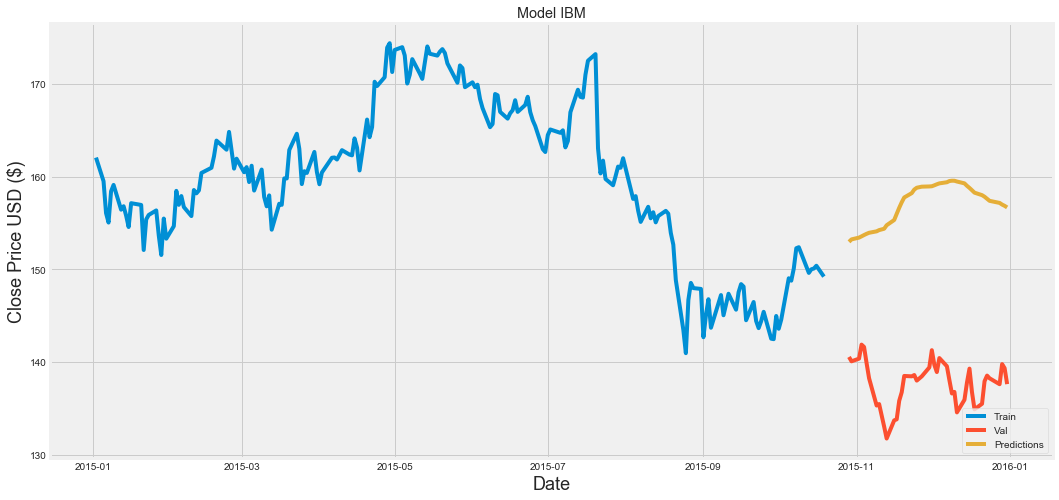

Ticker:  IBM
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
lookback is:  20
lookahead is:  7
years_window is:  2
length of test window:  70
normalization method:  min_max
 
starting output loop for ticker:  AAPL
train shape  (200, 14)
valid shape  (43, 14)
predictions[company] shape  (50, 1)
key dimension predictions[company].shape[0]-look_ahead:  43
things you want  43


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


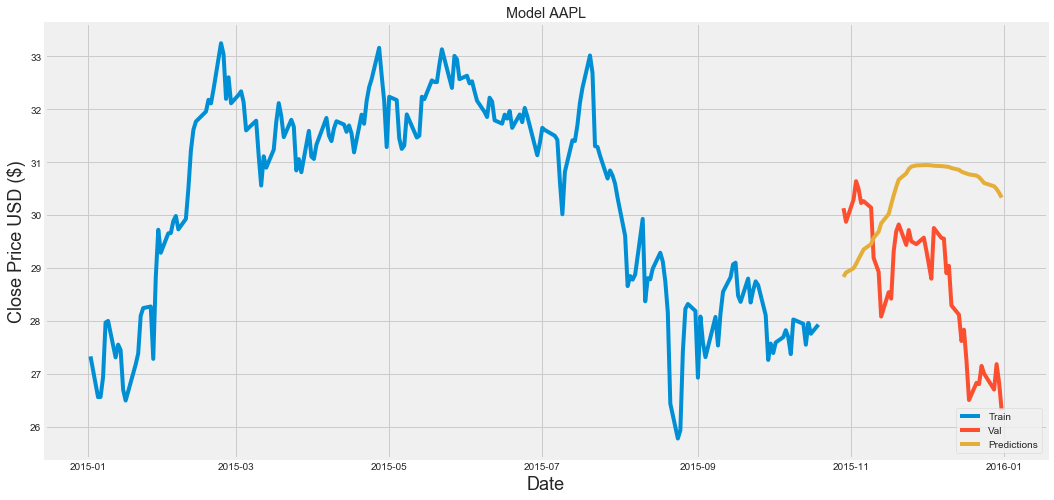

Ticker:  AAPL
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
lookback is:  20
lookahead is:  7
years_window is:  2
length of test window:  70
normalization method:  min_max
 
starting output loop for ticker:  MSFT
train shape  (200, 14)
valid shape  (43, 14)
predictions[company] shape  (50, 1)
key dimension predictions[company].shape[0]-look_ahead:  43
things you want  43


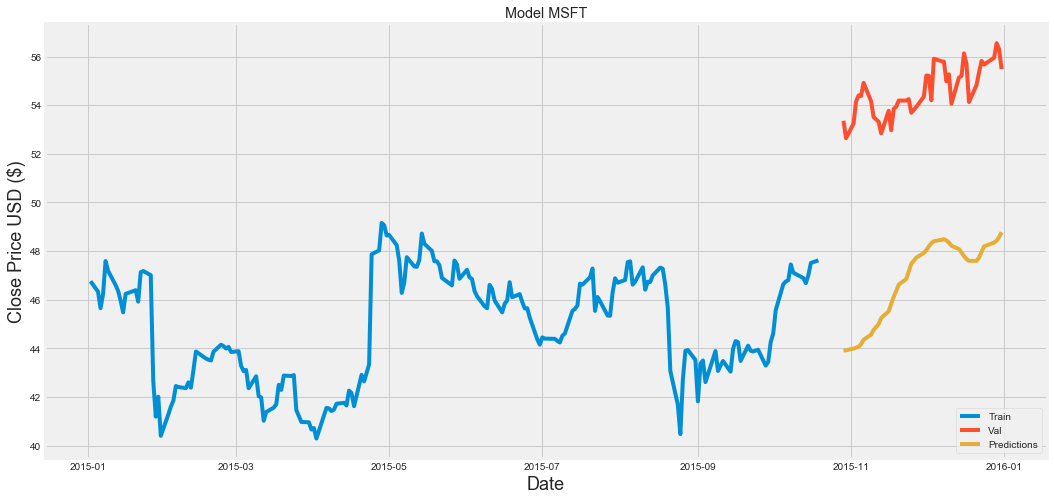

Ticker:  MSFT
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
lookback is:  20
lookahead is:  7
years_window is:  2
length of test window:  70
normalization method:  min_max
 
close_threshold:  0.01
timeframe controlled by master_start and master_end:  True
beginning of timeframe:  2015-01-01'
end of timeframe:  '2016-01-01'
proportion of timeframe for training:  0.8
normalized stats
cols is run_id
parms[cols] 2
cols is master_date_mode
parms[cols] False
cols is master_start
parms[cols] '2010-01-01'
cols is master_end
parms[cols] '2016-01-01'
cols is repeatable_run
parms[cols] False
cols is years_window
parms[cols] 2
cols is training_proportion
parms[cols] 0.8
cols is close_threshold
parms[cols] 0.01
cols is look_back
parms[cols] 20
cols is look_ahead
parms[cols] 14
cols is look_ahead_scale
parms[cols] 0.5
cols is tec

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


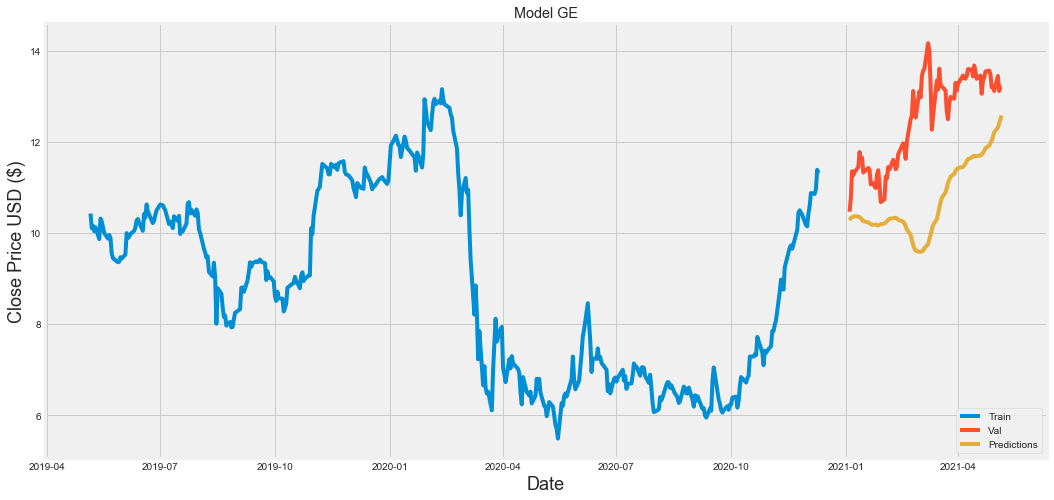

Ticker:  GE
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
lookback is:  20
lookahead is:  14
years_window is:  2
length of test window:  120
normalization method:  min_max
 
close_threshold:  0.01
timeframe controlled by master_start and master_end:  False
beginning of timeframe:  2019-05-06
end of timeframe:  2021-05-06
proportion of timeframe for training:  0.8
normalized stats
cols is run_id
parms[cols] 3
cols is master_date_mode
parms[cols] False
cols is master_start
parms[cols] '2010-01-01'
cols is master_end
parms[cols] '2016-01-01'
cols is repeatable_run
parms[cols] False
cols is years_window
parms[cols] 1
cols is training_proportion
parms[cols] 0.8
cols is close_threshold
parms[cols] 0.01
cols is look_back
parms[cols] 20
cols is look_ahead
parms[cols] 7
cols is look_ahead_scale
parms[cols] 0.5
cols is tech_l

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(253, 6)
building df for company:  ARNC
feature_list is  ['2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
temp_feature_list is  ['2 YR', '30 YR', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
exception not generated
building df for company:  ASML
feature_list is  ['2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
temp_feature_list is  ['2 YR', '30 YR', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
exception not generated
revised tech_list is:  ['ARNC', 'ASML']
 
TRAINING LOOP FOR:  ARNC
cols is: ['Close', '2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schill

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


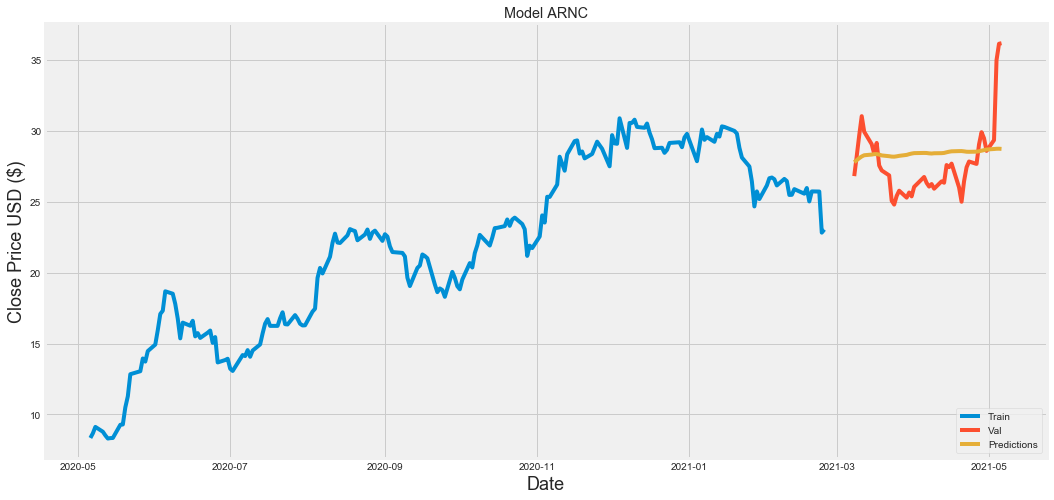

Ticker:  ARNC
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
lookback is:  20
lookahead is:  7
years_window is:  1
length of test window:  70
normalization method:  min_max
 
starting output loop for ticker:  ASML
train shape  (201, 14)
valid shape  (43, 14)
predictions[company] shape  (50, 1)
key dimension predictions[company].shape[0]-look_ahead:  43
things you want  43


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


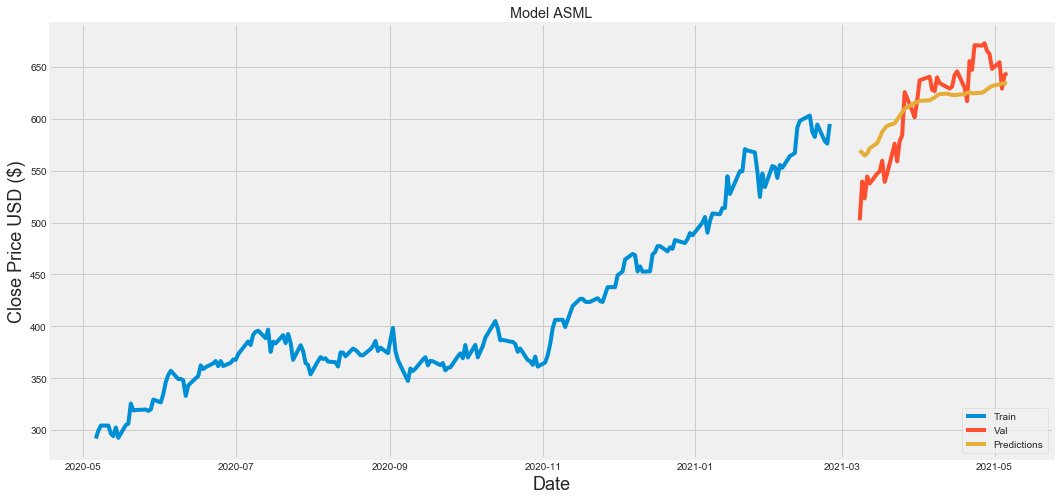

Ticker:  ASML
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Sector_Close', 'VIX', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']
lookback is:  20
lookahead is:  7
years_window is:  1
length of test window:  70
normalization method:  min_max
 
close_threshold:  0.01
timeframe controlled by master_start and master_end:  False
beginning of timeframe:  2020-05-06
end of timeframe:  2021-05-06
proportion of timeframe for training:  0.8
normalized stats
output table:  C:\personal\karma_stocks_2021\stock_investigation\output\summary20210506-222759.csv
Notebook execution duration:  0:03:00.924072


,run_id,master_date_mode,master_start,master_end,repeatable_run,years_window,training_proportion,close_threshold,look_back,look_ahead,look_ahead_scale,tech_list,ticker,total deviation,avg deviation,max deviation,min deviation,proportion good days
0,3,False,'2010-01-01','2016-01-01',False,1,0.8,0.01,20,7,0.5,"[ARNC, ASML]",ARNC,3.1609,2.0492,0.2676,0.0007,4.0%
1,3,False,'2010-01-01','2016-01-01',False,1,0.8,0.01,20,7,0.5,"[ARNC, ASML]",ASML,1.6480,23.3813,0.1102,0.0023,10.0%


In [64]:
# main block to call all the subsidiary functions and loop through the parm CSV, if required
first_multi = True
if multi_parm_run:
    # read the multi_parm CSV file and for each row in it, do an iteration
    multi_file = os.path.join(get_data_path(),multi_parm_file)
    print("multi_file: ",multi_file)
    # df_multi_parm = pd.read_csv(multi_file,encoding = "ISO-8859-1")
    df_multi_parm = pd.read_csv(multi_file)
    print("multi_parm cols are", df_multi_parm.columns)
    # for index, row in df.iterrows():
    #print(row['c1'], row['c2'])
    for index, row in df_multi_parm.iterrows():
        # for each row in the multi_parm CSV file
        for cols in df_multi_parm.columns:
            # for col in the current row in the multi_parm CSV file, replace the current parm value with the one in the CSV file for that row
            if cols in list_parms:
                # parm is a list, so convert string version into Python list
                parms[cols] = row[cols].strip('][').split(', ')
            else:
                parms[cols] = row[cols]
            print("cols is",cols)
            print("parms[cols]",parms[cols])
        # now with the parms set, run the whole iteration
        start, end = set_start_end()
        df_predict, tech_list = define_main_df(start, end, parms['tech_list'])
        # no-op for this entry if no valid tickers
        if len(tech_list) > 0:
            predictions,data,training_data_len,look_ahead_dict,test_data = model_train(start, end,parms['tech_list'],df_predict,parms['look_ahead'],parms['look_back'],parms['training_proportion'])
            summary_df = plot_data(start, end,parms['master_date_mode'],row,parms['tech_list'], predictions,data,training_data_len,look_ahead_dict,parms['look_back'],test_data,parms['training_proportion']) 
            if first_multi:
                first_multi = False
                output_df = summary_df
            else:
                output_df = pd.concat([output_df, summary_df])        
    str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
    file_name = os.path.join(get_path(),"summary"+str_date+".csv")
    print("output table: ",file_name)
    try:
        output_df.to_csv(file_name,index=False)
    except Exception as f:
        if debug_on:
            raise
            print("exception generated "+str(f)+" attempting to write output CSV "+file_name)
        else:
            print("exception not generated")
else:
    # just do one iteration using the parms from the config file
    row = []
    start, end = set_start_end()
    df_predict, tech_list = define_main_df(start, end, parms['tech_list'])
    # no-op if no valid tickers
    if len(tech_list) > 0:
        predictions,data,training_data_len,look_ahead_dict,test_data = model_train(start, end,parms['tech_list'],df_predict,parms['look_ahead'],parms['look_back'],parms['training_proportion'])
        summary_df = plot_data(start, end,parms['master_date_mode'],row,parms['tech_list'], predictions,data,training_data_len,look_ahead_dict,parms['look_back'],test_data,parms['training_proportion'])
        str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
        file_name = os.path.join(get_path(),"summary"+str_date+".csv")
        print("output table: ",file_name)
        summary_df.to_csv(file_name,index=False)
#
# total deviation = sum of difference between actual price and prediction, normalized by average cost
# avg deviation = average difference between actual price and prediction
# max deviation = highest difference between actual price and prediction, normalized by average cost
# proportion good days = proportion of days where difference between actual price and prediction (normalized by avg cost)
# was less than close_threshold value in config file
print("Notebook execution duration: ",str(datetime.now() - start_timestamp))
summary_df.head()
